# Practice: Multi step model (simple encoder-decoder)

In this notebook, we walk through:
- preparing the time series data for training a RNN forecasting model
- getting data in the required shape for the keras API
- implement a RNN model in keras to predict the next 3 steps ahead (time *t+1* to *t+3*) in the time series. This model uses a simple encoder decoder approach in which the final hidden state of the encoder is replicated across each time step of the decoder. 
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

import numpy as np
np.set_printoptions(precision=2)

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Load data into Pandas dataframe

In [2]:
import os

# Insert code START
file_name = os.path.join('data', 'energy.parquet')
energy = pd.read_parquet(file_name)
# Insert code END
assert energy.shape == (26304, 2)
energy.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


## Create train, validation and test sets

We separate our dataset into train, validation and test sets. We train the model on the train set. The validation set is used to evaluate the model after each training epoch and ensure that the model is not overfitting the training data. After the model has finished training, we evaluate the model on the test set. We must ensure that the validation set and test set cover a later period in time from the training set, to ensure that the model does not gain from information from future time periods.

We will allocate the period 1st November 2014 to 31st December 2014 to the test set. The period 1st September 2014 to 31st October is allocated to validation set. All other time periods are available for the training set.

In [3]:
# Insert code START
valid_start_dt = '2014-08-31 23:30:00'
test_start_dt = '2014-10-31 23:30:00'
# Insert code END

train = energy.copy()[:valid_start_dt]
valid = energy.copy()[valid_start_dt:test_start_dt]
test = energy.copy()[test_start_dt:]

assert train.index.max() == pd.to_datetime('2014-08-31 23:00:00')
assert valid.index.min() == pd.to_datetime('2014-09-01 00:00:00')
assert valid.index.max() == pd.to_datetime('2014-10-31 23:00:00')
assert test.index.min() == pd.to_datetime('2014-11-01 00:00:00')

## Data preparation

For this example, we will set *T=6*. This means that the input for each sample is a vector of the prevous 6 hours of the energy load. The choice of *T=6* was arbitrary but should be selected through experimentation.

*HORIZON=1* specifies that we have a forecasting horizon of 3 (*t+1*, *t+2*, *t+3*)

In [4]:
T = 6
HORIZON = 3

### Create training set:

1. Scale (This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.)
2. Create TiemSeriesTensor 

In [5]:
from sklearn.preprocessing import MinMaxScaler

# Fit a scaler for the y values
y_scaler = MinMaxScaler()
y_scaler.fit(train[['load']])

# Also scale the input features data (load and temp values)
X_scaler = MinMaxScaler()
train[['load', 'temp']] = X_scaler.fit_transform(train)
valid[['load', 'temp']] = X_scaler.transform(valid)
test[['load', 'temp']] = X_scaler.transform(test)

In [6]:
from common.utils import TimeSeriesTensor

tensor_structure = {'X':(range(-T+1, 1), ['load', 'temp'])}
train_inputs = TimeSeriesTensor(dataset=train,
                            target='load',
                            H=HORIZON,
                            tensor_structure=tensor_structure,
                            freq='H',
                            drop_incomplete=True)


X_train = train_inputs['X']
y_train = train_inputs['target']

assert y_train.shape == (23368, 3)
assert X_train.shape == (23368, 6, 2)

### Construct validation set 
(keeping T hours from the training set in order to construct initial features)

In [7]:
# In order to allow T lags, we need to add the last T-1 train samples to the validation set
valid = pd.concat([train.iloc[-(T-1):], valid])

# Create TimeSeriesTensor
valid_inputs = TimeSeriesTensor(valid, 'load', HORIZON, tensor_structure)
y_valid = valid_inputs['target']
X_valid = valid_inputs['X']

assert y_valid.shape == (1461, 3)
assert X_valid.shape == (1461, 6, 2)

## Quiz: Implement an encoder-decoder RNN

![Encoder-Decoder](./images/encoder_decoder_multilayer.png)

Implement your RNN model with the data prepared above and the following requirements:
1. Use 2 features: past load and temperature
2. Stack 2 **LSTM** layers for the encoder RNN
3. 12 hidden units in the first LSTM layer
4. 6 hidden units in the second LSTM layer
5. Repeat the vector output of the second encoder layer 3 times (one for each time step in the forecast horizon)
5. Add a decoder LSTM with 6 hidden units
6. 5 epochs
7. Batch size 32

The model will have the following structure:

In [8]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [9]:
ENCODER_LAYER_1_DIM = 12
ENCODER_LAYER_2_DIM = 6
DECODER_DIM = 6
BATCH_SIZE = 32
EPOCHS = 5

In [10]:
model = Sequential()
# Insert code BEGIN
model.add(LSTM(ENCODER_LAYER_1_DIM, input_shape=(T, 2), return_sequences=True))
model.add(LSTM(ENCODER_LAYER_2_DIM))
model.add(RepeatVector(HORIZON))
model.add(LSTM(DECODER_DIM, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
# Insert code END
model.add(Flatten())

In [11]:
model.compile(optimizer='RMSprop', loss='mse')

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6, 12)             720       
_________________________________________________________________
lstm_2 (LSTM)                (None, 6)                 456       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 3, 6)              0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 3, 6)              312       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 3, 1)              7         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3)                 0         
Total params: 1,495
Trainable params: 1,495
Non-trainable params: 0
____________________________________________________

In [13]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [14]:
history = model.fit(
    train_inputs['X'],
    train_inputs['target'],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(valid_inputs['X'], valid_inputs['target']),
    callbacks=[earlystop],
    verbose=1
)

Train on 23368 samples, validate on 1461 samples
Epoch 1/5
23368/23368 [==============================] - 8s 326us/step - loss: 0.0259 - val_loss: 0.0077
Epoch 2/5
23368/23368 [==============================] - 6s 270us/step - loss: 0.0078 - val_loss: 0.0050
Epoch 3/5
23368/23368 [==============================] - 6s 266us/step - loss: 0.0053 - val_loss: 0.0046
Epoch 4/5
23368/23368 [==============================] - 6s 271us/step - loss: 0.0043 - val_loss: 0.0031
Epoch 5/5
23368/23368 [==============================] - 6s 268us/step - loss: 0.0038 - val_loss: 0.0040


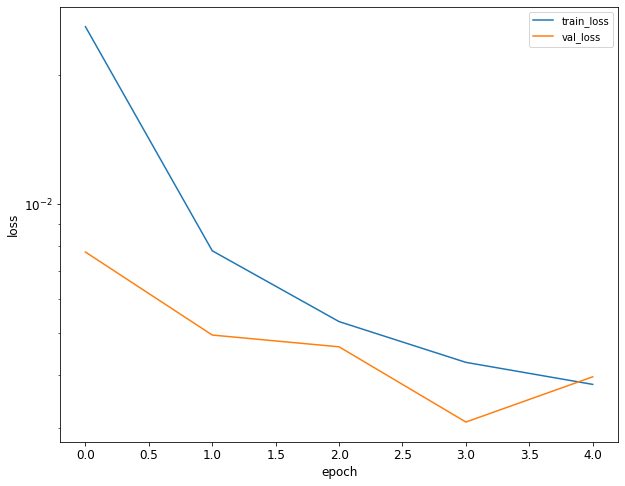

In [15]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,8), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

## Evaluate the model

In [16]:
# In order to allow T lags, we need to add the last T-1 validation samples to the test set
test = pd.concat([valid.iloc[-(T-1):], test])

# Create TimeSeriesTensor
test_inputs = TimeSeriesTensor(test, 'load', HORIZON, tensor_structure)
y_test = test_inputs['target']
X_test = test_inputs['X']

assert y_test.shape == (1461, 3)
assert X_test.shape == (1461, 6, 2)

In [17]:
predictions = model.predict(test_inputs['X'])

In [18]:
predictions

array([[0.11, 0.12, 0.14],
       [0.12, 0.15, 0.18],
       [0.12, 0.16, 0.21],
       ...,
       [0.56, 0.51, 0.46],
       [0.51, 0.45, 0.4 ],
       [0.48, 0.44, 0.39]], dtype=float32)

In [19]:
from common.utils import create_evaluation_df

eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scaler)
eval_df.head()

,timestamp,h,prediction,actual
0,2014-11-01 00:00:00,t+1,"2,351.64","2,434.00"
1,2014-11-01 01:00:00,t+1,"2,371.16","2,390.00"
2,2014-11-01 02:00:00,t+1,"2,380.14","2,382.00"
3,2014-11-01 03:00:00,t+1,"2,420.84","2,419.00"
4,2014-11-01 04:00:00,t+1,"2,490.10","2,520.00"


In [20]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean() * 100

h
t+1   4.03
t+2   5.02
t+3   6.65
Name: APE, dtype: float64

In [21]:
from common.utils import mape

print('MAPE: {:.2f}%'.format(100 * mape(eval_df['prediction'], eval_df['actual'])))

MAPE: 5.23%


Plot actuals vs predictions at each horizon for first week of the test period. As is to be expected, predictions for one step ahead (*t+1*) are more accurate than those for 2 or 3 steps ahead

No handles with labels found to put in legend.


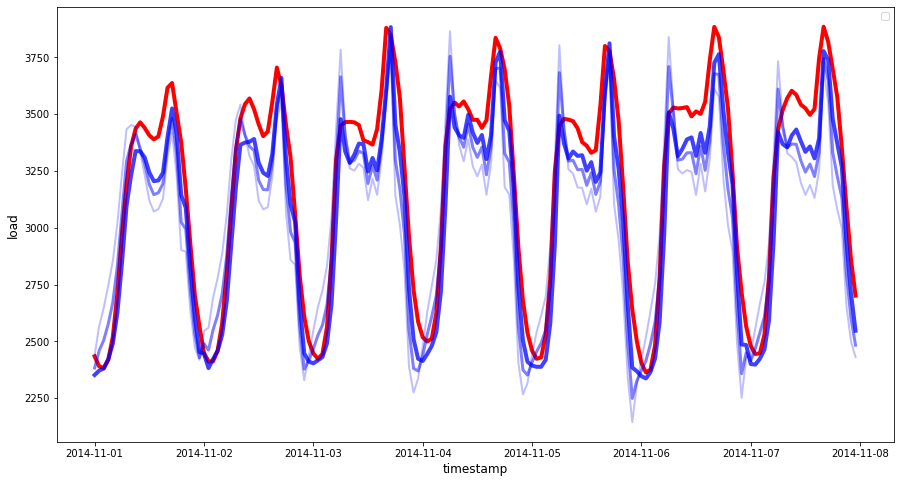

In [22]:
plot_df = eval_df[(eval_df.timestamp<'2014-11-08') & (eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[(eval_df.timestamp<'2014-11-08') & (eval_df.h=='t+'+str(t))]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5)
ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.show()